# Problem 3. Comparison of MLP and CNN
In this assignment, you will compare two models ( MLP & CNN)




## Import libraries including PyTorch

In [1]:
#Importing all libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import PIL
from PIL import Image
from torchvision import datasets 


## Load the data

In [2]:
train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(p=0.5),
     #transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR), ##DATA AUGMENTATION 
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]   


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## A CNN Model with MaxPooling layers from Problem 2
You can copy the model below. Then, train and obtain the necessary analyzation data.


In [3]:
"""

USE CNN Model from Problem 2 in CNN_problem_2.ipynb

"""
###########################################################################
# PLACE YOUR CODE HERE                                                    #
###########################################################################
import torch.nn as nn
import torch.nn.functional as F

class CNN_Max(nn.Module):
  """
  A convolutional neural network (CNN). In this CNN object, we will use following
  dimensions:

  input_size: the dimension d of the input data.                        
  hidden_size: the number of neurons h in the hidden layer.             
  output_size: the number of classes c, which is 10 in our task          
  """
  def __init__(self):
    """
    An initialization function. This object of network is a simple feed-forward 
    network. It takes an input to pass to muitiple layers. Then, provide the 
    output. The layers are initialized after their creation. 

    In this problem, we will use following set of parameters building a CNN/

    conv: convolutional kernel size, which is 3 by 3 with bias                         
    pool: pooling kernel-size, which is 2 by 2    
    dropout: random zeroing layer with probability 0.4                            
    fc: fully-connected layer which uses affine operation y=Wx+b              

    Parameters
    ----------
    N/A
    """
    super(CNN_Max, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 

    self.conv_32 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, bias=True)
    self.bn_32 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
    self.conv_64 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=True)
    self.bn_64 = nn.BatchNorm2d(64)

    self.linear_64 = nn.Linear(in_features=64 * 22 * 22, out_features=64)
    self.linear_bn_64 = nn.BatchNorm1d(64)
    self.linear_32 = nn.Linear(in_features=64, out_features=32)
    self.linear_bn_32 = nn.BatchNorm1d(32)
    self.linear_10 = nn.Linear(in_features=32, out_features=10)

    self.dropout_05 = nn.Dropout(p=0.5)
    self.dropout_02 = nn.Dropout(p=0.5)


    #############################################################################
   

  def forward(self, x):
    """
    A forward pass function. Using the pre-defined network modules, we can here 
    build a model designing its structure. 

    Parameters
    ---------- 
    x: matrix  
      an input data of shape (1, d, d), where d is the dimension of the input 
      image. 
  
    Returns
    ---------- 
    out:     
      an output data given x.

    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    #out = F.relu(self.conv_32(x))
    #out = self.pool(out)
    #out = F.relu(self.conv_64(out))
    #out = self.pool(out)

    out = self.conv_32(x)
    #out = self.bn_32(out)
    out = F.relu(out)
    out = self.pool(out)
    #out = self.dropout(out)

    out = self.conv_64(out)
    #out = self.bn_64(out)
    out = F.relu(out)
    out = self.pool(out)
    #out = self.dropout(out)

    out = out.view(-1, 64 * 22 * 22)

    out = F.relu(self.linear_64(out))
    #out = self.linear_bn_64(out)
    #out = self.dropout_05(out)
    out = F.relu(self.linear_32(out))
    #out = self.linear_bn_32(out)
    #out = self.dropout_05(out)
    out = self.linear_10(out)

    #############################################################################

    return out


# END OF YOUR CODE                           
###########################################################################

In [4]:
"""

Train the CNN model

"""
import torch.optim as optim

###########################################################################
# PLACE YOUR CODE HERE                                                    #
###########################################################################
net = CNN_Max()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
#############################################################################
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(30):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    """

    First, set the gradients to zero. Then obtain predictions from your CNN   
    model. After that, pass into loss to calculate the difference between the 
    prediction and labels. Next, you have to compute the gradients with       
    respect to the tensor.  


    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()


 
    #############################################################################
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))


# END OF YOUR CODE                           
###########################################################################

Device: cuda:0
[epoch 1] loss: 0.00497 accuracy: 0.7642 val loss: 0.00388 val accuracy: 0.8174
[epoch 2] loss: 0.00290 accuracy: 0.8655 val loss: 0.00267 val accuracy: 0.8777
[epoch 3] loss: 0.00245 accuracy: 0.8866 val loss: 0.00245 val accuracy: 0.8894
[epoch 4] loss: 0.00215 accuracy: 0.8987 val loss: 0.00240 val accuracy: 0.8888
[epoch 5] loss: 0.00193 accuracy: 0.9091 val loss: 0.00219 val accuracy: 0.9002
[epoch 6] loss: 0.00176 accuracy: 0.9175 val loss: 0.00212 val accuracy: 0.9025
[epoch 7] loss: 0.00163 accuracy: 0.9239 val loss: 0.00212 val accuracy: 0.9034
[epoch 8] loss: 0.00146 accuracy: 0.9305 val loss: 0.00200 val accuracy: 0.9117
[epoch 9] loss: 0.00135 accuracy: 0.9353 val loss: 0.00184 val accuracy: 0.9189
[epoch 10] loss: 0.00125 accuracy: 0.9413 val loss: 0.00188 val accuracy: 0.9206
[epoch 11] loss: 0.00110 accuracy: 0.9475 val loss: 0.00195 val accuracy: 0.9173
[epoch 12] loss: 0.00103 accuracy: 0.9519 val loss: 0.00187 val accuracy: 0.9183
[epoch 13] loss: 0.000

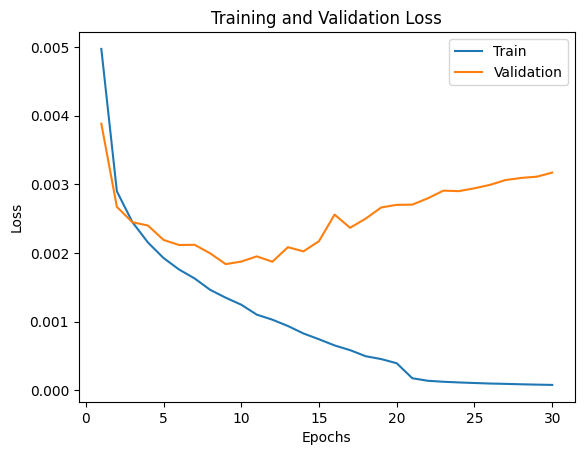

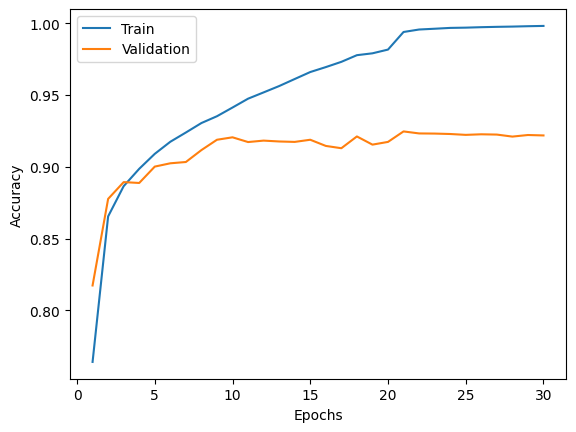

In [5]:
"""

Visualize a plot of validation accuracy curves from
the CNN model

"""
###########################################################################
# PLACE YOUR CODE HERE                                                    #
###########################################################################
import matplotlib.pyplot as plt

"""

  You have to plot two graphs, one for loss of training and validation data 
  and second one for accuarcy of training and validation data.              
  Set x-axis to number of epochs and y-axis to loss or accuracy. Set legend 
  equal to training and validation set.                                      

"""
legend = ['Train', 'Validation']
#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 


 # Number of epochs
epochs = range(1, len(loss_hist) + 1)

# Plot the loss graph
plt.figure()
plt.plot(epochs, loss_hist, label='Train')
plt.plot(epochs, loss_hist_val, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Plot the accuracy graph
plt.figure()
plt.plot(epochs, acc_hist, label='Train')
plt.plot(epochs, acc_hist_val, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')



 
#############################################################################
plt.legend(legend, loc='upper left')
plt.show()
    

# END OF YOUR CODE                           
###########################################################################

In [6]:
# Testing the CNN model on test data
net.eval()  # Set the network to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 92.32%


## An MLP model with ReLU layers similar to the assignment 1

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Problem 2: Implementing your own CNN
# a. Convolution and MaxPooling layers


class MLP(nn.Module):
  """
  A multilayer perceptrons (MLP). In this MLP object, we will use following
  dimensions:

  input_size: the dimension d of the input data.                        
  hidden_size: the number of neurons h in the hidden layer.             
  output_size: the number of classes c, which is 10 in our task          
  """
  def __init__(self):
    """
    An initialization function. This object of network is a simple feed-forward 
    network. It takes an input to pass to muitiple layers. Then, provide the 
    output. The layers are initialized after their creation. 

    Parameters
    ----------
    N/A
    """
    super(MLP, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # TODO: design your fully connected layers
    # E.g., self.fc1 = ?, self.fc2 = ?, self.fc3 = ? 
    self.fc1 = nn.Linear(784, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 10)




    #############################################################################
   

  def forward(self, x):
    """
    A forward pass function. Using the pre-defined network modules, we can here 
    build a model designing its structure. 

    Parameters
    ---------- 
    x: matrix  
      an input data of shape (1, d, d), where d is the dimension of the input 
      image. 
  
    Returns
    ---------- 
    out:     
      an output data given x.

    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # TODO: construct the fully connected neural network given x
    out = x.view(x.size(0), -1)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)

    #############################################################################

    return out

# create a CNN object
net2 = MLP()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net2.to(device)

num_params = sum(p.numel() for p in net2.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

from torchsummary import summary
summary(net2,(1,28,28))

Device: cuda:0
Number of trainable parameters: 55050
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
            Linear-2                   [-1, 64]           4,160
            Linear-3                   [-1, 10]             650
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [8]:
import torch.optim as optim

"""

 You have to define the loss, for that please use cross entropy loss      
 Also, you must implement optimizer called SGD.                           

"""

#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 
# TODO: declare your optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)



#############################################################################
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(30):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    """

    First, set the gradients to zero. Then obtain predictions from your CNN   
    model. After that, pass into loss to calculate the difference between the 
    prediction and labels. Next, you have to compute the gradients with       
    respect to the tensor.  


    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # todo optimizer and loss
    optimizer.zero_grad()
    outputs = net2(batch)
    loss = criterion(outputs, labels)
    loss.backward()



    #############################################################################
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net2.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net2(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net2.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))
     

[epoch 1] loss: 0.00555 accuracy: 0.7491 val loss: 0.00386 val accuracy: 0.8206
[epoch 2] loss: 0.00345 accuracy: 0.8401 val loss: 0.00328 val accuracy: 0.8525
[epoch 3] loss: 0.00308 accuracy: 0.8569 val loss: 0.00318 val accuracy: 0.8515
[epoch 4] loss: 0.00286 accuracy: 0.8666 val loss: 0.00297 val accuracy: 0.8629
[epoch 5] loss: 0.00272 accuracy: 0.8721 val loss: 0.00292 val accuracy: 0.8669
[epoch 6] loss: 0.00261 accuracy: 0.8796 val loss: 0.00288 val accuracy: 0.8700
[epoch 7] loss: 0.00250 accuracy: 0.8828 val loss: 0.00270 val accuracy: 0.8783
[epoch 8] loss: 0.00239 accuracy: 0.8880 val loss: 0.00313 val accuracy: 0.8561
[epoch 9] loss: 0.00231 accuracy: 0.8921 val loss: 0.00275 val accuracy: 0.8759
[epoch 10] loss: 0.00223 accuracy: 0.8955 val loss: 0.00266 val accuracy: 0.8802
[epoch 11] loss: 0.00217 accuracy: 0.8984 val loss: 0.00270 val accuracy: 0.8744
[epoch 12] loss: 0.00212 accuracy: 0.8990 val loss: 0.00273 val accuracy: 0.8798
[epoch 13] loss: 0.00208 accuracy: 0.

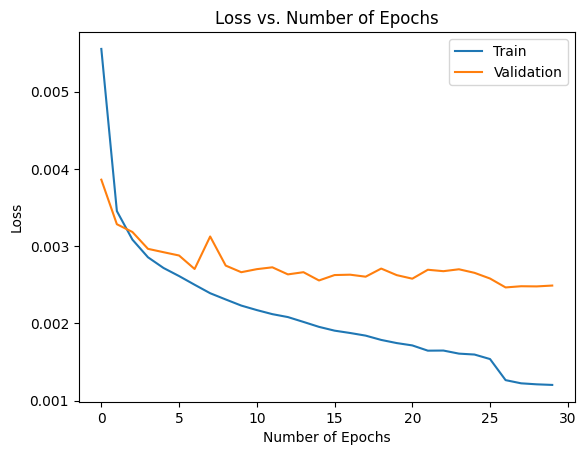

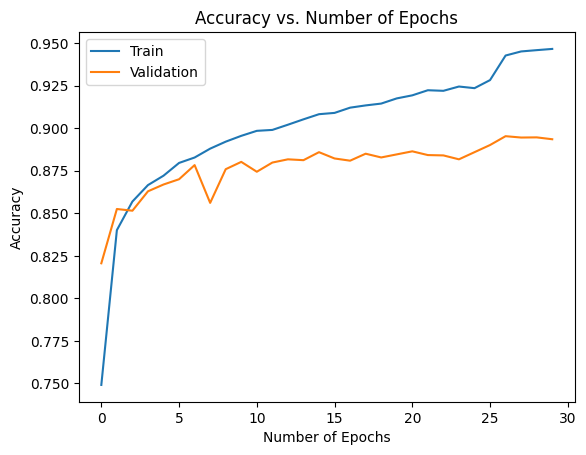

In [9]:
import matplotlib.pyplot as plt

"""

  You have to plot two graphs, one for loss of training and validation data 
  and second one for accuarcy of training and validation data.              
  Set x-axis to number of epochs and y-axis to loss or accuracy. Set legend 
  equal to training and validation set.                                      a

"""
legend = ['Train', 'Validation']
#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 

# Plot loss
plt.figure()
plt.plot(loss_hist, label='Train')
plt.plot(loss_hist_val, label='Validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Epochs')
plt.legend(legend, loc='upper right')

# Plot accuracy
plt.figure()
plt.plot(acc_hist, label='Train')
plt.plot(acc_hist_val, label='Validation')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.legend(legend, loc='upper left')



#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################
plt.legend(legend, loc='upper left')
plt.show()


In [10]:
# Testing the CNN model on test data
net2.eval()  # Set the network to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 88.70%
